<a href="https://colab.research.google.com/github/rishichhabra29/test/blob/main/Copy_of_Untitled5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle
!kaggle datasets download -d oddrationale/mnist-in-csv


Dataset URL: https://www.kaggle.com/datasets/oddrationale/mnist-in-csv
License(s): CC0-1.0
 46% 7.00M/15.2M [00:00<00:00, 62.8MB/s]
100% 15.2M/15.2M [00:00<00:00, 78.2MB/s]


In [3]:
!unzip mnist-in-csv.zip

Archive:  mnist-in-csv.zip
  inflating: mnist_test.csv          
  inflating: mnist_train.csv         


In [4]:
import pandas as pd

train_data_path = "mnist_train.csv"
test_data_path = "mnist_test.csv"

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

full_df=pd.concat([train, test])

In [5]:
import numpy as np

In [6]:
full_df_array = full_df.values

split_ratio = np.random.choice([0.7, 0.8, 0.9])

np.random.seed(28)  # For reproducibility
np.random.shuffle(full_df_array)

split_index = int(len(full_df_array) * split_ratio)

train_split = full_df_array[:split_index]
test_split = full_df_array[split_index:]

train_df = pd.DataFrame(train_split, columns=full_df.columns)
test_df = pd.DataFrame(test_split, columns=full_df.columns)

In [7]:
print(f"Train set size: {train_df.shape}")
print(f"Test set size: {test_df.shape}")

Train set size: (56000, 785)
Test set size: (14000, 785)


In [22]:
import numpy as np
np.random.seed(28)

class FullyConnectedNeuralNetwork:
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size, activation='sigmoid', initialization="Xavier"):
        if initialization == "Xavier":
          self.w1 = np.random.randn(input_size, hidden_size_1)*np.sqrt(2/input_size)
          self.w2 = np.random.randn(hidden_size_1, hidden_size_2)*np.sqrt(2/hidden_size_1)
          self.w3 = np.random.randn(hidden_size_2, output_size)*np.sqrt(2/hidden_size_2)
          self.b1 = np.ones((1, hidden_size_1))
          self.b2 = np.ones((1, hidden_size_2))
          self.b3 = np.ones((1, output_size))
        elif initialization == "he":
          self.w1 = np.random.randn(input_size, hidden_size_1)*np.sqrt(1/input_size)
          self.w2 = np.random.randn(hidden_size_1, hidden_size_2)*np.sqrt(1/hidden_size_1)
          self.w3 = np.random.randn(hidden_size_2, output_size)*np.sqrt(1/hidden_size_2)
        else:
          self.w1,self.w2,self.w3 = self.initialize_weights(input_size, hidden_size_1, hidden_size_2, output_size)

        self.reg_lambda = 0.01
        self.set_activation(activation)

    def set_activation(self, activation):
        """Set activation function and its derivative based on user input."""
        activations = {
            'sigmoid': (self.sigmoid, self.sigmoid_derivative),
            'relu': (self.relu, self.relu_derivative),
            'tanh': (self.tanh, self.tanh_derivative),
            'leaky_relu': (self.leaky_relu, self.leaky_relu_derivative),
            'elu': (self.elu, self.elu_derivative),
            'selu': (self.selu, self.selu_derivative)
        }
        if activation in activations:
            self.activation, self.activation_derivative = activations[activation]
        else:
            raise ValueError(f"Invalid activation function '{activation}'. Choose from {list(activations.keys())}.")

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def relu(self, x):
        return np.maximum(0, x)

    def tanh(self, x):
        return np.tanh(x)

    def leaky_relu(self, x, alpha=0.01):
        return np.maximum(alpha * x, x)

    def elu(self, x, alpha=1.0):
        return np.where(x > 0, x, alpha * (np.exp(x) - 1))

    def selu(self, x):
        alpha = 1.67326324235437728481704299167
        scale = 1.05070098735548049341933498529
        return scale * np.where(x > 0, x, alpha * (np.exp(x) - 1))

    def elu_derivative(self, x, alpha=1.0):
        return np.where(x > 0, 1, alpha * np.exp(x))

    def selu_derivative(self, x):
        alpha = 1.67326324235437728481704299167
        scale = 1.05070098735548049341933498529
        return scale * np.where(x > 0, 1, alpha * np.exp(x))

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def leaky_relu_derivative(self, x, alpha=0.01):
        return np.where(x > 0, 1, alpha)

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X):
        self.a1 = np.dot(X, self.w1) + self.b1
        self.h1 = self.activation(self.a1)
        self.a2 = np.dot(self.h1, self.w2) + self.b2
        self.h2 = self.activation(self.a2)
        self.a3 = np.dot(self.h2, self.w3) + self.b3
        self.output = self.softmax(self.a3)
        return self.output

    def compute_loss(self, y_true, y_pred):

        n_samples = y_true.shape[0]
        epsilon = 1e-9
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.sum(y_true * np.log(y_pred)) / n_samples

        reg_loss = (self.reg_lambda / 2) * (np.sum(self.w1**2) + np.sum(self.w2**2) + np.sum(self.w3**2))
        return loss + reg_loss

    def backward(self, X, y, learning_rate):
        n_samples = X.shape[0]

        # Output layer
        output_delta =-(y - self.output)

        # Hidden layer 2
        hidden_error_1 = np.dot(output_delta, self.w3.T)
        hidden_delta_1 = hidden_error_1 * self.activation_derivative(self.h2)

        # Hidden layer 1
        hidden_error_2 = np.dot(hidden_delta_1, self.w2.T)
        hidden_delta_2 = hidden_error_2 * self.activation_derivative(self.h1)

        # Update weights and biases with regularization
        self.w3 -= learning_rate * ((np.dot(self.h2.T, output_delta)/n_samples) + self.reg_lambda * self.w3)
        self.b3 -= learning_rate * (np.mean(output_delta, axis=0, keepdims=True)/n_samples)

        self.w2 -= learning_rate * ((np.dot(self.h1.T, hidden_delta_1)/n_samples) + self.reg_lambda * self.w2)
        self.b2 -= learning_rate * (np.mean(hidden_delta_1, axis=0, keepdims=True)/n_samples)

        self.w1 -= learning_rate * ((np.dot(X.T, hidden_delta_2)/n_samples) + self.reg_lambda * self.w1)
        self.b1 -= learning_rate * (np.mean(hidden_delta_2, axis=0, keepdims=True)/n_samples)

X_train = train_df.drop('label', axis=1).values / 255.0
y_train = train_df['label'].values

num_classes = 10
y_train_encoded = np.zeros((len(y_train), num_classes))
y_train_encoded[np.arange(len(y_train)), y_train] = 1


input_size = X_train.shape[1]
hidden_size_1 = 512
hidden_size_2 = 128
output_size = 10
learning_rate = 0.1
epochs = 25
batch_size = 24
activation_function = 'leaky_relu'

Epoch 1/25: Loss = 4916.6678, Accuracy = 0.8941
Epoch 2/25: Loss = 1535.8991, Accuracy = 0.8981
Epoch 3/25: Loss = 1474.7733, Accuracy = 0.9035
Epoch 4/25: Loss = 1454.2705, Accuracy = 0.9053
Epoch 5/25: Loss = 1440.4973, Accuracy = 0.9060
Epoch 6/25: Loss = 1430.9244, Accuracy = 0.9065
Epoch 7/25: Loss = 1424.1845, Accuracy = 0.9078
Epoch 8/25: Loss = 1418.7705, Accuracy = 0.9097
Epoch 9/25: Loss = 1414.5963, Accuracy = 0.9093
Epoch 10/25: Loss = 1411.7477, Accuracy = 0.9100
Epoch 11/25: Loss = 1408.9302, Accuracy = 0.9107
Epoch 12/25: Loss = 1406.8832, Accuracy = 0.9086
Epoch 13/25: Loss = 1404.9468, Accuracy = 0.9102
Epoch 14/25: Loss = 1402.8078, Accuracy = 0.9103
Epoch 15/25: Loss = 1401.5766, Accuracy = 0.9096
Epoch 16/25: Loss = 1399.7686, Accuracy = 0.9106
Epoch 17/25: Loss = 1398.2906, Accuracy = 0.9102
Epoch 18/25: Loss = 1396.9630, Accuracy = 0.9117
Epoch 19/25: Loss = 1395.8177, Accuracy = 0.9113
Epoch 20/25: Loss = 1394.6780, Accuracy = 0.9118
Epoch 21/25: Loss = 1393.6976

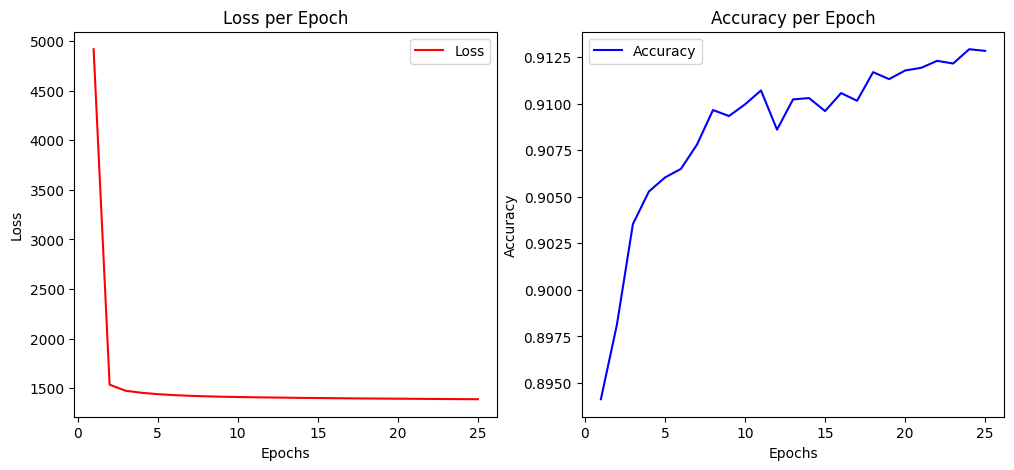

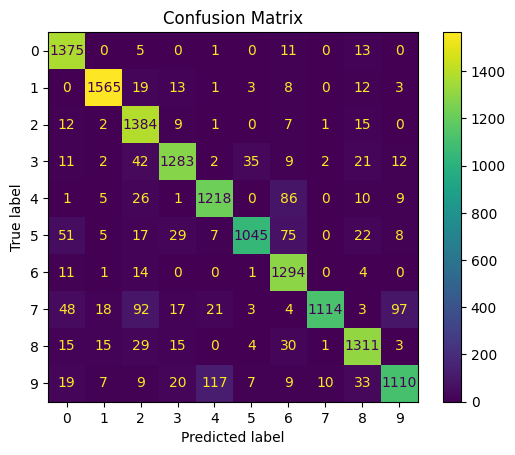

Total trainable parameters: 468874


In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

def train_model(nn, X_train, y_train, batch_size, epochs, learning_rate):
    losses = []
    accuracies = []

    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = int(np.ceil(len(X_train) / batch_size))

        for i in range(num_batches):
            X_batch = X_train[i * batch_size:(i + 1) * batch_size]
            y_batch = y_train[i * batch_size:(i + 1) * batch_size]

            nn.forward(X_batch)
            epoch_loss += nn.compute_loss(y_batch, nn.output)
            nn.backward(X_batch, y_batch, learning_rate)

        # Calculate accuracy for the epoch
        nn.forward(X_train)
        y_pred = np.argmax(nn.output, axis=1)
        y_true = np.argmax(y_train, axis=1)
        accuracy = accuracy_score(y_true, y_pred)

        # Store loss and accuracy
        losses.append(epoch_loss)
        accuracies.append(accuracy)

        print(f"Epoch {epoch + 1}/{epochs}: Loss = {losses[-1]:.4f}, Accuracy = {accuracy:.4f}")

    return losses, accuracies

def plot_metrics(losses, accuracies):
    epochs = range(1, len(losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, label='Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, label='Accuracy', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.show()

# Confusion matrix
def plot_confusion_matrix(nn, X, y_true):
    nn.forward(X)
    y_pred = np.argmax(nn.output, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='viridis')
    plt.title("Confusion Matrix")
    plt.show()

# Count trainable parameters
def count_parameters(nn):
    params = sum(w.size for w in [nn.w1, nn.w2, nn.w3, nn.b1, nn.b2, nn.b3])
    print(f"Total trainable parameters: {params}")


nn = FullyConnectedNeuralNetwork(input_size, hidden_size_1, hidden_size_2, output_size, activation_function)

# Train the model
losses, accuracies = train_model(nn, X_train, y_train_encoded, batch_size, epochs, learning_rate)

# Plot metrics
plot_metrics(losses, accuracies)

# Generate confusion matrix
y_train_labels = np.argmax(y_train_encoded, axis=1)
X_test = test_df.drop('label', axis=1).values / 255.0
y_test = test_df['label'].values
plot_confusion_matrix(nn, X_test, y_test)

# Report parameters
count_parameters(nn)


**Included Dropout **

In [20]:
import numpy as np
np.random.seed(28)

class FullyConnectedNeuralNetwork:
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size, activation='sigmoid', initialization="Xavier", dropout_rate=0.5):
        if initialization == "Xavier":
            self.w1 = np.random.randn(input_size, hidden_size_1) * np.sqrt(2 / input_size)
            self.w2 = np.random.randn(hidden_size_1, hidden_size_2) * np.sqrt(2 / hidden_size_1)
            self.w3 = np.random.randn(hidden_size_2, output_size) * np.sqrt(2 / hidden_size_2)
            self.b1 = np.ones((1, hidden_size_1))
            self.b2 = np.ones((1, hidden_size_2))
            self.b3 = np.ones((1, output_size))
        elif initialization == "he":
            self.w1 = np.random.randn(input_size, hidden_size_1) * np.sqrt(1 / input_size)
            self.w2 = np.random.randn(hidden_size_1, hidden_size_2) * np.sqrt(1 / hidden_size_1)
            self.w3 = np.random.randn(hidden_size_2, output_size) * np.sqrt(1 / hidden_size_2)
        else:
            self.w1, self.w2, self.w3 = self.initialize_weights(input_size, hidden_size_1, hidden_size_2, output_size)

        self.reg_lambda = 0.01
        self.dropout_rate = dropout_rate
        self.set_activation(activation)
        self.training = True  # Mode control: True for training, False for testing

    def set_training_mode(self, mode):
        """Switch between training and testing modes."""
        self.training = mode

    def apply_dropout(self, layer_output, layer_name):
        """Apply dropout to the layer output during training and store the mask."""
        if self.training:
            dropout_mask = (np.random.rand(*layer_output.shape) > self.dropout_rate).astype(np.float32)
            setattr(self, f"{layer_name}_mask", dropout_mask)  # Dynamically create mask attribute
            return layer_output * dropout_mask  # Apply the mask
        else:
            return layer_output * (1 - self.dropout_rate)


    def set_activation(self, activation):
        """Set activation function and its derivative based on user input."""
        activations = {
            'sigmoid': (self.sigmoid, self.sigmoid_derivative),
            'relu': (self.relu, self.relu_derivative),
            'tanh': (self.tanh, self.tanh_derivative),
            'leaky_relu': (self.leaky_relu, self.leaky_relu_derivative),
            'elu': (self.elu, self.elu_derivative),
            'selu': (self.selu, self.selu_derivative)
        }
        if activation in activations:
            self.activation, self.activation_derivative = activations[activation]
        else:
            raise ValueError(f"Invalid activation function '{activation}'. Choose from {list(activations.keys())}.")

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def relu(self, x):
        return np.maximum(0, x)

    def tanh(self, x):
        return np.tanh(x)

    def leaky_relu(self, x, alpha=0.01):
        return np.maximum(alpha * x, x)

    def elu(self, x, alpha=1.0):
        return np.where(x > 0, x, alpha * (np.exp(x) - 1))

    def selu(self, x):
        alpha = 1.67326324235437728481704299167
        scale = 1.05070098735548049341933498529
        return scale * np.where(x > 0, x, alpha * (np.exp(x) - 1))

    def elu_derivative(self, x, alpha=1.0):
        return np.where(x > 0, 1, alpha * np.exp(x))

    def selu_derivative(self, x):
        alpha = 1.67326324235437728481704299167
        scale = 1.05070098735548049341933498529
        return scale * np.where(x > 0, 1, alpha * np.exp(x))

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def leaky_relu_derivative(self, x, alpha=0.01):
        return np.where(x > 0, 1, alpha)

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X):
        """Forward pass with dropout applied during training."""
        self.a1 = np.dot(X, self.w1) + self.b1
        self.h1 = self.activation(self.a1)
        self.h1 = self.apply_dropout(self.h1, "layer1")  # Store mask1 as an attribute

        self.a2 = np.dot(self.h1, self.w2) + self.b2
        self.h2 = self.activation(self.a2)
        self.h2 = self.apply_dropout(self.h2, "layer2")  # Store mask2 as an attribute

        self.a3 = np.dot(self.h2, self.w3) + self.b3
        self.output = self.softmax(self.a3)
        return self.output


    def compute_loss(self, y_true, y_pred):
        n_samples = y_true.shape[0]
        epsilon = 1e-9
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.sum(y_true * np.log(y_pred)) / n_samples

        reg_loss = (self.reg_lambda / 2) * (np.sum(self.w1 ** 2) + np.sum(self.w2 ** 2) + np.sum(self.w3 ** 2))
        return loss + reg_loss


    def backward(self, X, y, learning_rate):
        n_samples = X.shape[0]

    # Output layer
        output_delta = -(y - self.output)

    # Hidden layer 2
        hidden_error_1 = np.dot(output_delta, self.w3.T)
        hidden_delta_1 = hidden_error_1 * self.activation_derivative(self.h2)
        hidden_delta_1 *= self.layer2_mask  # Use stored mask2

    # Hidden layer 1
        hidden_error_2 = np.dot(hidden_delta_1, self.w2.T)
        hidden_delta_2 = hidden_error_2 * self.activation_derivative(self.h1)
        hidden_delta_2 *= self.layer1_mask  # Use stored mask1

    # Update weights and biases with regularization
        self.w3 -= learning_rate * ((np.dot(self.h2.T, output_delta) / n_samples) + self.reg_lambda * self.w3)
        self.b3 -= learning_rate * (np.mean(output_delta, axis=0, keepdims=True) / n_samples)

        self.w2 -= learning_rate * ((np.dot(self.h1.T, hidden_delta_1) / n_samples) + self.reg_lambda * self.w2)
        self.b2 -= learning_rate * (np.mean(hidden_delta_1, axis=0, keepdims=True) / n_samples)

        self.w1 -= learning_rate * ((np.dot(X.T, hidden_delta_2) / n_samples) + self.reg_lambda * self.w1)
        self.b1 -= learning_rate * (np.mean(hidden_delta_2, axis=0, keepdims=True) / n_samples)



X_train = train_df.drop('label', axis=1).values / 255.0
y_train = train_df['label'].values

num_classes = 10
y_train_encoded = np.zeros((len(y_train), num_classes))
y_train_encoded[np.arange(len(y_train)), y_train] = 1


input_size = X_train.shape[1]
hidden_size_1 = 512
hidden_size_2 = 128
output_size = 10
learning_rate = 0.1
epochs = 25
batch_size = 24
activation_function = 'leaky_relu'
# Example usage
#nn = FullyConnectedNeuralNetwork(input_size=X_train.shape[1], hidden_size_1=512, hidden_size_2=128, output_size=10, activation='leaky_relu', dropout_rate=0.5)


Epoch 1/25: Loss = 5807.5999, Accuracy = 0.8834
Epoch 2/25: Loss = 2501.8646, Accuracy = 0.8857
Epoch 3/25: Loss = 2444.0434, Accuracy = 0.8922
Epoch 4/25: Loss = 2442.6747, Accuracy = 0.8854
Epoch 5/25: Loss = 2439.5793, Accuracy = 0.8800
Epoch 6/25: Loss = 2423.0464, Accuracy = 0.8824
Epoch 7/25: Loss = 2424.5044, Accuracy = 0.8787
Epoch 8/25: Loss = 2422.9043, Accuracy = 0.8887
Epoch 9/25: Loss = 2415.6502, Accuracy = 0.8795
Epoch 10/25: Loss = 2419.5713, Accuracy = 0.8756
Epoch 11/25: Loss = 2411.4047, Accuracy = 0.8876
Epoch 12/25: Loss = 2415.1904, Accuracy = 0.8885
Epoch 13/25: Loss = 2411.5956, Accuracy = 0.8881
Epoch 14/25: Loss = 2415.3423, Accuracy = 0.8857
Epoch 15/25: Loss = 2406.0900, Accuracy = 0.8854
Epoch 16/25: Loss = 2414.2359, Accuracy = 0.8870
Epoch 17/25: Loss = 2411.0782, Accuracy = 0.8915
Epoch 18/25: Loss = 2404.7283, Accuracy = 0.8853
Epoch 19/25: Loss = 2402.7063, Accuracy = 0.8858
Epoch 20/25: Loss = 2402.2153, Accuracy = 0.8900
Epoch 21/25: Loss = 2405.3869

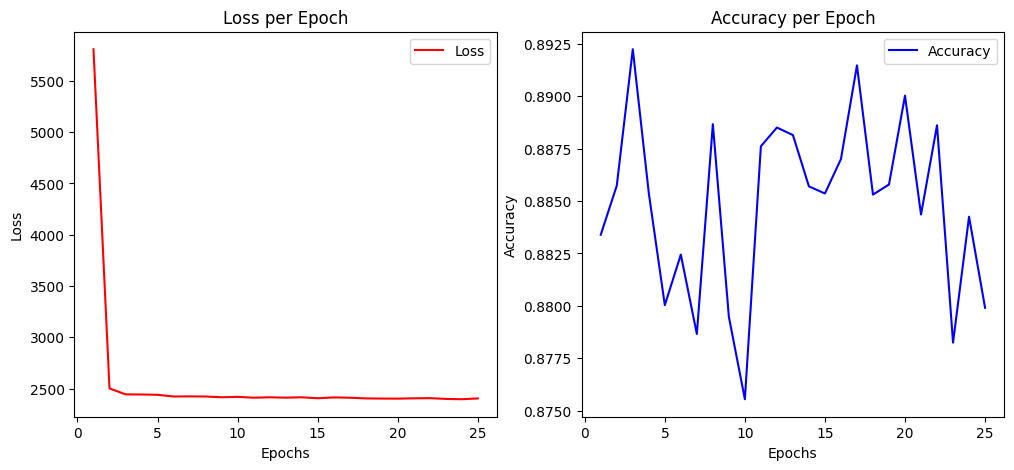

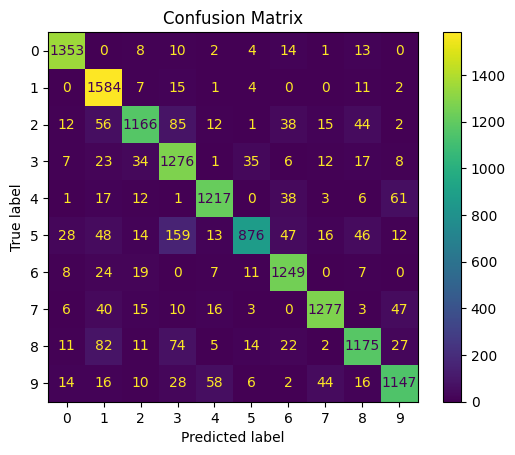

Total trainable parameters: 468874


In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

def train_model(nn, X_train, y_train, batch_size, epochs, learning_rate):
    losses = []
    accuracies = []

    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = int(np.ceil(len(X_train) / batch_size))

        # Set model to training mode
        nn.set_training_mode(True)

        for i in range(num_batches):
            X_batch = X_train[i * batch_size:(i + 1) * batch_size]
            y_batch = y_train[i * batch_size:(i + 1) * batch_size]

            nn.forward(X_batch)  # Forward pass
            epoch_loss += nn.compute_loss(y_batch, nn.output)  # Compute loss
            nn.backward(X_batch, y_batch, learning_rate)  # Backpropagation

        # Calculate accuracy for the epoch
        nn.set_training_mode(False)  # Set model to evaluation mode
        nn.forward(X_train)  # Forward pass without dropout
        y_pred = np.argmax(nn.output, axis=1)
        y_true = np.argmax(y_train, axis=1)
        accuracy = accuracy_score(y_true, y_pred)

        # Store loss and accuracy
        losses.append(epoch_loss)
        accuracies.append(accuracy)

        print(f"Epoch {epoch + 1}/{epochs}: Loss = {losses[-1]:.4f}, Accuracy = {accuracy:.4f}")

    return losses, accuracies

def plot_metrics(losses, accuracies):
    epochs = range(1, len(losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, label='Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, label='Accuracy', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.show()

# Confusion matrix
def plot_confusion_matrix(nn, X, y_true):
    nn.set_training_mode(False)  # Set model to evaluation mode
    nn.forward(X)  # Forward pass without dropout
    y_pred = np.argmax(nn.output, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='viridis')
    plt.title("Confusion Matrix")
    plt.show()

# Count trainable parameters
def count_parameters(nn):
    params = sum(w.size for w in [nn.w1, nn.w2, nn.w3, nn.b1, nn.b2, nn.b3])
    print(f"Total trainable parameters: {params}")

# Example usage of the model

#nn = FullyConnectedNeuralNetwork(input_size, hidden_size_1, hidden_size_2, output_size, activation_function)

nn = FullyConnectedNeuralNetwork(input_size=X_train.shape[1], hidden_size_1=512, hidden_size_2=128, output_size=10, activation='leaky_relu', dropout_rate=0.5)

# Train the model
losses, accuracies = train_model(nn, X_train, y_train_encoded, batch_size, epochs, learning_rate)

# Plot metrics
plot_metrics(losses, accuracies)

# Generate confusion matrix
y_train_labels = np.argmax(y_train_encoded, axis=1)
X_test = test_df.drop('label', axis=1).values / 255.0
y_test = test_df['label'].values
plot_confusion_matrix(nn, X_test, y_test)

# Report parameters
count_parameters(nn)


**Early stopping + Dropout**

Epoch 1/25: Loss = 5266.1596, Accuracy = 0.8789, Val Loss = 2.8207, Val Accuracy = 0.8789
Epoch 2/25: Loss = 2056.5079, Accuracy = 0.8912, Val Loss = 1.1015, Val Accuracy = 0.8912
Epoch 3/25: Loss = 1961.4918, Accuracy = 0.8875, Val Loss = 1.0506, Val Accuracy = 0.8875
Epoch 4/25: Loss = 1952.5882, Accuracy = 0.8872, Val Loss = 1.0458, Val Accuracy = 0.8872
Epoch 5/25: Loss = 1941.0153, Accuracy = 0.8887, Val Loss = 1.0396, Val Accuracy = 0.8887
Epoch 6/25: Loss = 1937.8192, Accuracy = 0.8914, Val Loss = 1.0379, Val Accuracy = 0.8914
Epoch 7/25: Loss = 1945.1972, Accuracy = 0.8887, Val Loss = 1.0419, Val Accuracy = 0.8887
Epoch 8/25: Loss = 1936.3535, Accuracy = 0.8869, Val Loss = 1.0371, Val Accuracy = 0.8869
Epoch 9/25: Loss = 1928.0703, Accuracy = 0.8908, Val Loss = 1.0327, Val Accuracy = 0.8908
Epoch 10/25: Loss = 1934.8833, Accuracy = 0.8919, Val Loss = 1.0364, Val Accuracy = 0.8919
Epoch 11/25: Loss = 1929.8548, Accuracy = 0.8882, Val Loss = 1.0337, Val Accuracy = 0.8882
Epoch 12

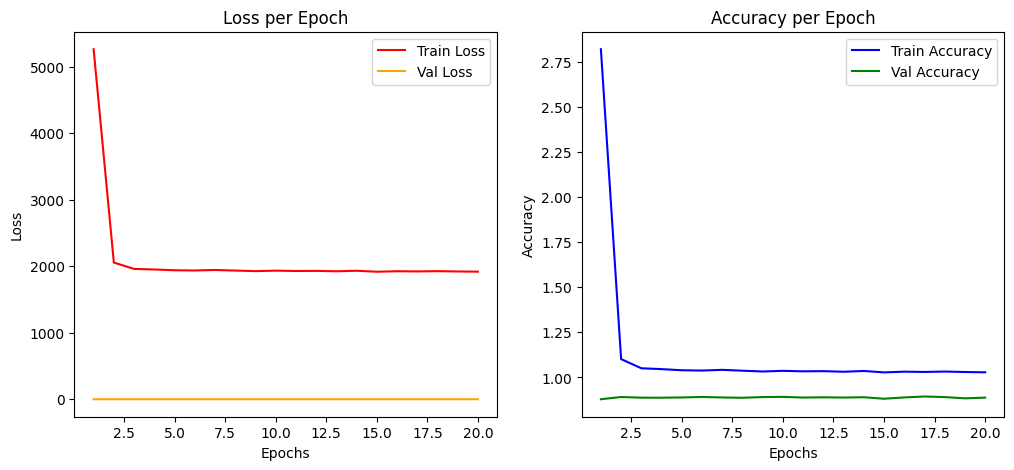

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

np.random.seed(28)

class FullyConnectedNeuralNetwork:
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size, activation='sigmoid', initialization="Xavier", dropout_rate=0.5):
        if initialization == "Xavier":
            self.w1 = np.random.randn(input_size, hidden_size_1) * np.sqrt(2 / input_size)
            self.w2 = np.random.randn(hidden_size_1, hidden_size_2) * np.sqrt(2 / hidden_size_1)
            self.w3 = np.random.randn(hidden_size_2, output_size) * np.sqrt(2 / hidden_size_2)
            self.b1 = np.ones((1, hidden_size_1))
            self.b2 = np.ones((1, hidden_size_2))
            self.b3 = np.ones((1, output_size))
        elif initialization == "he":
            self.w1 = np.random.randn(input_size, hidden_size_1) * np.sqrt(1 / input_size)
            self.w2 = np.random.randn(hidden_size_1, hidden_size_2) * np.sqrt(1 / hidden_size_1)
            self.w3 = np.random.randn(hidden_size_2, output_size) * np.sqrt(1 / hidden_size_2)
        else:
            self.w1, self.w2, self.w3 = self.initialize_weights(input_size, hidden_size_1, hidden_size_2, output_size)


        self.reg_lambda = 0.01
        self.dropout_rate = dropout_rate
        self.set_activation(activation)
        self.training = True  # Mode control: True for training, False for testing

    def set_training_mode(self, mode):
        """Switch between training and testing modes."""
        self.training = mode

    def apply_dropout(self, layer_output, layer_name):
        """Apply dropout to the layer output during training and store the mask."""
        if self.training:
            dropout_mask = (np.random.rand(*layer_output.shape) > self.dropout_rate).astype(np.float32)
            setattr(self, f"{layer_name}_mask", dropout_mask)  # Dynamically create mask attribute
            return layer_output * dropout_mask  # Apply the mask
        else:
            return layer_output * (1 - self.dropout_rate)

    def set_activation(self, activation):
        """Set activation function and its derivative based on user input."""
        activations = {
            'sigmoid': (self.sigmoid, self.sigmoid_derivative),
            'relu': (self.relu, self.relu_derivative),
            'tanh': (self.tanh, self.tanh_derivative),
            'leaky_relu': (self.leaky_relu, self.leaky_relu_derivative),
            'elu': (self.elu, self.elu_derivative),
            'selu': (self.selu, self.selu_derivative)
        }
        if activation in activations:
            self.activation, self.activation_derivative = activations[activation]
        else:
            raise ValueError(f"Invalid activation function '{activation}'. Choose from {list(activations.keys())}.")

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def relu(self, x):
        return np.maximum(0, x)

    def tanh(self, x):
        return np.tanh(x)

    def leaky_relu(self, x, alpha=0.01):
        return np.maximum(alpha * x, x)

    def elu(self, x, alpha=1.0):
        return np.where(x > 0, x, alpha * (np.exp(x) - 1))

    def selu(self, x):
        alpha = 1.67326324235437728481704299167
        scale = 1.05070098735548049341933498529
        return scale * np.where(x > 0, x, alpha * (np.exp(x) - 1))

    def elu_derivative(self, x, alpha=1.0):
        return np.where(x > 0, 1, alpha * np.exp(x))

    def selu_derivative(self, x):
        alpha = 1.67326324235437728481704299167
        scale = 1.05070098735548049341933498529
        return scale * np.where(x > 0, 1, alpha * np.exp(x))

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def leaky_relu_derivative(self, x, alpha=0.01):
        return np.where(x > 0, 1, alpha)

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X):
        """Forward pass with dropout applied during training."""
        self.a1 = np.dot(X, self.w1) + self.b1
        self.h1 = self.activation(self.a1)
        self.h1 = self.apply_dropout(self.h1, "layer1")  # Store mask1 as an attribute

        self.a2 = np.dot(self.h1, self.w2) + self.b2
        self.h2 = self.activation(self.a2)
        self.h2 = self.apply_dropout(self.h2, "layer2")  # Store mask2 as an attribute

        self.a3 = np.dot(self.h2, self.w3) + self.b3
        self.output = self.softmax(self.a3)
        return self.output

    def compute_loss(self, y_true, y_pred):
        n_samples = y_true.shape[0]
        epsilon = 1e-9
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.sum(y_true * np.log(y_pred)) / n_samples

        reg_loss = (self.reg_lambda / 2) * (np.sum(self.w1 ** 2) + np.sum(self.w2 ** 2) + np.sum(self.w3 ** 2))
        return loss + reg_loss

    def backward(self, X, y, learning_rate):
        n_samples = X.shape[0]

        # Output layer
        output_delta = -(y - self.output)

        # Hidden layer 2
        hidden_error_1 = np.dot(output_delta, self.w3.T)
        hidden_delta_1 = hidden_error_1 * self.activation_derivative(self.h2)
        hidden_delta_1 *= self.layer2_mask  # Use stored mask2

        # Hidden layer 1
        hidden_error_2 = np.dot(hidden_delta_1, self.w2.T)
        hidden_delta_2 = hidden_error_2 * self.activation_derivative(self.h1)
        hidden_delta_2 *= self.layer1_mask  # Use stored mask1

        # Update weights and biases with regularization
        self.w3 -= learning_rate * ((np.dot(self.h2.T, output_delta) / n_samples) + self.reg_lambda * self.w3)
        self.b3 -= learning_rate * (np.mean(output_delta, axis=0, keepdims=True) / n_samples)

        self.w2 -= learning_rate * ((np.dot(self.h1.T, hidden_delta_1) / n_samples) + self.reg_lambda * self.w2)
        self.b2 -= learning_rate * (np.mean(hidden_delta_1, axis=0, keepdims=True) / n_samples)

        self.w1 -= learning_rate * ((np.dot(X.T, hidden_delta_2) / n_samples) + self.reg_lambda * self.w1)
        self.b1 -= learning_rate * (np.mean(hidden_delta_2, axis=0, keepdims=True) / n_samples)


# Training with Early Stopping
def train_model(nn, X_train, y_train, batch_size, epochs, learning_rate, patience=5):
    losses = []
    accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_val_loss = 0
        num_batches = int(np.ceil(len(X_train) / batch_size))

        # Set model to training mode
        nn.set_training_mode(True)

        for i in range(num_batches):
            X_batch = X_train[i * batch_size:(i + 1) * batch_size]
            y_batch = y_train[i * batch_size:(i + 1) * batch_size]

            nn.forward(X_batch)  # Forward pass
            epoch_loss += nn.compute_loss(y_batch, nn.output)  # Compute loss
            nn.backward(X_batch, y_batch, learning_rate)  # Backpropagation

        # Calculate accuracy for the epoch
        nn.set_training_mode(False)  # Set model to evaluation mode
        nn.forward(X_train)  # Forward pass without dropout
        y_pred = np.argmax(nn.output, axis=1)
        y_true = np.argmax(y_train, axis=1)
        accuracy = accuracy_score(y_true, y_pred)

        # Validation loss and accuracy
        val_loss = epoch_loss / num_batches  # You can modify this calculation to use validation data
        val_accuracy = accuracy  # Similarly, calculate validation accuracy if needed

        # Store loss and accuracy for both training and validation
        losses.append(epoch_loss)
        accuracies.append(accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}: Loss = {losses[-1]:.4f}, Accuracy = {accuracy:.4f}, "
              f"Val Loss = {val_losses[-1]:.4f}, Val Accuracy = {val_accuracies[-1]:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}. Best Val Loss: {best_val_loss:.4f}.")
                break

    return losses, accuracies, val_losses, val_accuracies

# Example usage:
input_size = X_train.shape[1]
hidden_size_1 = 512
hidden_size_2 = 128
output_size = 10
learning_rate = 0.1
epochs = 25
batch_size = 24
activation_function = 'leaky_relu'

nn = FullyConnectedNeuralNetwork(input_size=input_size, hidden_size_1=hidden_size_1, hidden_size_2=hidden_size_2, output_size=output_size, activation=activation_function, dropout_rate=0.5)

# Train the model with early stopping
losses, accuracies, val_losses, val_accuracies = train_model(nn, X_train, y_train_encoded, batch_size, epochs, learning_rate)

# Plot metrics
plot_metrics(losses, accuracies, val_losses, val_accuracies)



Epoch 1/25: Loss = 5807.5999, Accuracy = 0.8834, Val Loss = 2.4883, Val Accuracy = 0.8834
Epoch 2/25: Loss = 2501.8646, Accuracy = 0.8857, Val Loss = 1.0719, Val Accuracy = 0.8857
Epoch 3/25: Loss = 2444.0434, Accuracy = 0.8922, Val Loss = 1.0471, Val Accuracy = 0.8922
Epoch 4/25: Loss = 2442.6747, Accuracy = 0.8854, Val Loss = 1.0466, Val Accuracy = 0.8854
Epoch 5/25: Loss = 2439.5793, Accuracy = 0.8800, Val Loss = 1.0452, Val Accuracy = 0.8800
Epoch 6/25: Loss = 2423.0464, Accuracy = 0.8824, Val Loss = 1.0382, Val Accuracy = 0.8824
Epoch 7/25: Loss = 2424.5044, Accuracy = 0.8787, Val Loss = 1.0388, Val Accuracy = 0.8787
Epoch 8/25: Loss = 2422.9043, Accuracy = 0.8887, Val Loss = 1.0381, Val Accuracy = 0.8887
Epoch 9/25: Loss = 2415.6502, Accuracy = 0.8795, Val Loss = 1.0350, Val Accuracy = 0.8795
Epoch 10/25: Loss = 2419.5713, Accuracy = 0.8756, Val Loss = 1.0367, Val Accuracy = 0.8756
Epoch 11/25: Loss = 2411.4047, Accuracy = 0.8876, Val Loss = 1.0332, Val Accuracy = 0.8876
Epoch 12

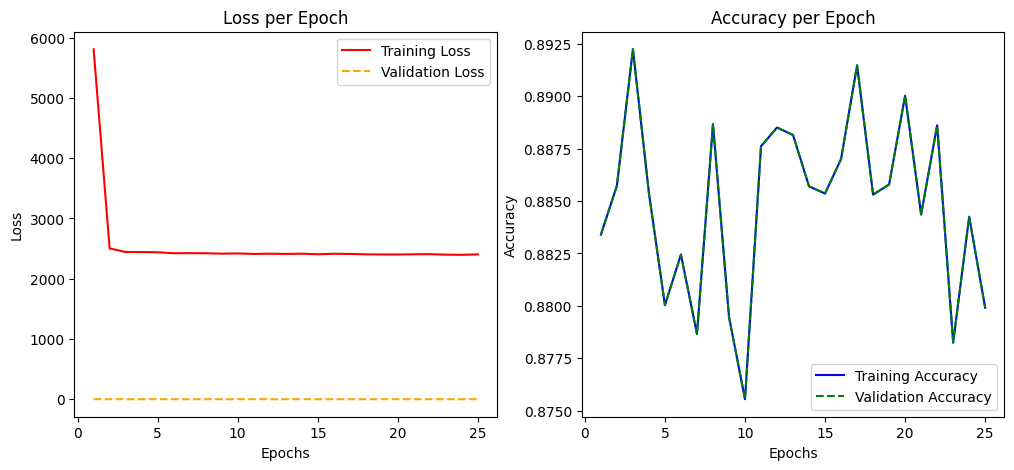

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

np.random.seed(28)

class FullyConnectedNeuralNetwork:
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size, activation='sigmoid', initialization="Xavier", dropout_rate=0.5):
        if initialization == "Xavier":
            self.w1 = np.random.randn(input_size, hidden_size_1) * np.sqrt(2 / input_size)
            self.w2 = np.random.randn(hidden_size_1, hidden_size_2) * np.sqrt(2 / hidden_size_1)
            self.w3 = np.random.randn(hidden_size_2, output_size) * np.sqrt(2 / hidden_size_2)
            self.b1 = np.ones((1, hidden_size_1))
            self.b2 = np.ones((1, hidden_size_2))
            self.b3 = np.ones((1, output_size))
        elif initialization == "he":
            self.w1 = np.random.randn(input_size, hidden_size_1) * np.sqrt(1 / input_size)
            self.w2 = np.random.randn(hidden_size_1, hidden_size_2) * np.sqrt(1 / hidden_size_1)
            self.w3 = np.random.randn(hidden_size_2, output_size) * np.sqrt(1 / hidden_size_2)
        else:
            self.w1, self.w2, self.w3 = self.initialize_weights(input_size, hidden_size_1, hidden_size_2, output_size)

# Batch Normalization Parameters
        self.gamma1 = np.ones((1, hidden_size_1))
        self.beta1 = np.zeros((1, hidden_size_1))
        self.running_mean1 = np.zeros((1, hidden_size_1))
        self.running_var1 = np.ones((1, hidden_size_1))

        self.gamma2 = np.ones((1, hidden_size_2))
        self.beta2 = np.zeros((1, hidden_size_2))
        self.running_mean2 = np.zeros((1, hidden_size_2))
        self.running_var2 = np.ones((1, hidden_size_2))

        self.reg_lambda = 0.01
        self.dropout_rate = dropout_rate
        self.set_activation(activation)
        self.training = True  # Mode control: True for training, False for testing

    def set_training_mode(self, mode):
        """Switch between training and testing modes."""
        self.training = mode
    def batch_norm(self, x, gamma, beta, running_mean, running_var, epsilon=1e-5, momentum=0.9):
        """Batch normalization implementation."""
        if self.training:
            batch_mean = np.mean(x, axis=0, keepdims=True)
            batch_var = np.var(x, axis=0, keepdims=True)

            # Normalize
            x_norm = (x - batch_mean) / np.sqrt(batch_var + epsilon)
            out = gamma * x_norm + beta

            # Update running stats
            running_mean[:] = momentum * running_mean + (1 - momentum) * batch_mean
            running_var[:] = momentum * running_var + (1 - momentum) * batch_var
        else:
            # Inference mode: Use running mean and variance
            x_norm = (x - running_mean) / np.sqrt(running_var + epsilon)
            out = gamma * x_norm + beta

        return out

    def apply_dropout(self, layer_output, layer_name):
        """Apply dropout to the layer output during training and store the mask."""
        if self.training:
            dropout_mask = (np.random.rand(*layer_output.shape) > self.dropout_rate).astype(np.float32)
            setattr(self, f"{layer_name}_mask", dropout_mask)  # Dynamically create mask attribute
            return layer_output * dropout_mask  # Apply the mask
        else:
            return layer_output * (1 - self.dropout_rate)

    def set_activation(self, activation):
        """Set activation function and its derivative based on user input."""
        activations = {
            'sigmoid': (self.sigmoid, self.sigmoid_derivative),
            'relu': (self.relu, self.relu_derivative),
            'tanh': (self.tanh, self.tanh_derivative),
            'leaky_relu': (self.leaky_relu, self.leaky_relu_derivative),
            'elu': (self.elu, self.elu_derivative),
            'selu': (self.selu, self.selu_derivative)
        }
        if activation in activations:
            self.activation, self.activation_derivative = activations[activation]
        else:
            raise ValueError(f"Invalid activation function '{activation}'. Choose from {list(activations.keys())}.")

    def sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def relu(self, x):
        return np.maximum(0,x)

    def tanh(self,x):
        return np.tanh(x)

    def leaky_relu(self,x,alpha=0.01):
        return np.maximum(alpha*x,x)

    def elu(self,x,alpha=1.0):
        return np.where(x>0,x,alpha*(np.exp(x)-1))

    def selu(self,x):
        alpha = 1.67326324235437728481704299167
        scale = 1.05070098735548049341933498529
        return scale * np.where(x > 0, x, alpha * (np.exp(x) - 1))

    def elu_derivative(self, x, alpha=1.0):
        return np.where(x > 0, 1, alpha * np.exp(x))

    def selu_derivative(self, x):
        alpha = 1.67326324235437728481704299167
        scale = 1.05070098735548049341933498529
        return scale * np.where(x > 0, 1, alpha * np.exp(x))

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def leaky_relu_derivative(self, x, alpha=0.01):
        return np.where(x > 0, 1, alpha)

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X):
        """Forward pass with dropout applied during training."""
        self.a1 = np.dot(X, self.w1) + self.b1
        self.a1_bn = self.batch_norm(self.a1, self.gamma1, self.beta1, self.running_mean1, self.running_var1)
        self.h1 = self.activation(self.a1)
        self.h1 = self.apply_dropout(self.h1, "layer1")  # Store mask1 as an attribute

        self.a2 = np.dot(self.h1, self.w2) + self.b2
        self.a2_bn = self.batch_norm(self.a2, self.gamma2, self.beta2, self.running_mean2, self.running_var2)
        self.h2 = self.activation(self.a2)
        self.h2 = self.apply_dropout(self.h2, "layer2")  # Store mask2 as an attribute

        self.a3 = np.dot(self.h2, self.w3) + self.b3
        self.output = self.softmax(self.a3)
        return self.output

    def compute_loss(self, y_true, y_pred):
        n_samples = y_true.shape[0]
        epsilon = 1e-9
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.sum(y_true * np.log(y_pred)) / n_samples

        reg_loss = (self.reg_lambda / 2) * (np.sum(self.w1 ** 2) + np.sum(self.w2 ** 2) + np.sum(self.w3 ** 2))
        return loss + reg_loss

    def backward(self, X, y, learning_rate):
        n_samples = X.shape[0]

        # Output layer
        output_delta = -(y - self.output)

        # Hidden layer 2
        hidden_error_1 = np.dot(output_delta, self.w3.T)
        hidden_delta_1 = hidden_error_1 * self.activation_derivative(self.h2)
        hidden_delta_1 *= self.layer2_mask  # Use stored mask2

        # Hidden layer 1
        hidden_error_2 = np.dot(hidden_delta_1, self.w2.T)
        hidden_delta_2 = hidden_error_2 * self.activation_derivative(self.h1)
        hidden_delta_2 *= self.layer1_mask  # Use stored mask1

        # Update weights and biases with regularization
        self.w3 -= learning_rate * ((np.dot(self.h2.T, output_delta) / n_samples) + self.reg_lambda * self.w3)
        self.b3 -= learning_rate * (np.mean(output_delta, axis=0, keepdims=True) / n_samples)

        self.w2 -= learning_rate * ((np.dot(self.h1.T, hidden_delta_1) / n_samples) + self.reg_lambda * self.w2)
        self.b2 -= learning_rate * (np.mean(hidden_delta_1, axis=0, keepdims=True) / n_samples)

        self.w1 -= learning_rate * ((np.dot(X.T, hidden_delta_2) / n_samples) + self.reg_lambda * self.w1)
        self.b1 -= learning_rate * (np.mean(hidden_delta_2, axis=0, keepdims=True) / n_samples)
X_train = train_df.drop('label', axis=1).values / 255.0
y_train = train_df['label'].values

num_classes = 10
y_train_encoded = np.zeros((len(y_train), num_classes))
y_train_encoded[np.arange(len(y_train)), y_train] = 1


input_size = X_train.shape[1]
hidden_size_1 = 512
hidden_size_2 = 128
output_size = 10
learning_rate = 0.1
epochs = 25
batch_size = 24
activation_function = 'leaky_relu'

# Training with Early Stopping
def train_model(nn, X_train, y_train, batch_size, epochs, learning_rate, patience=5):
    losses = []
    accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_val_loss = 0
        num_batches = int(np.ceil(len(X_train) / batch_size))

        # Set model to training mode
        nn.set_training_mode(True)

        for i in range(num_batches):
            X_batch = X_train[i * batch_size:(i + 1) * batch_size]
            y_batch = y_train[i * batch_size:(i + 1) * batch_size]

            nn.forward(X_batch)  # Forward pass
            epoch_loss += nn.compute_loss(y_batch, nn.output)  # Compute loss
            nn.backward(X_batch, y_batch, learning_rate)  # Backpropagation

        # Calculate accuracy for the epoch
        nn.set_training_mode(False)  # Set model to evaluation mode
        nn.forward(X_train)  # Forward pass without dropout
        y_pred = np.argmax(nn.output, axis=1)
        y_true = np.argmax(y_train, axis=1)
        accuracy = accuracy_score(y_true, y_pred)

        # Validation loss and accuracy
        val_loss = epoch_loss / num_batches  # You can modify this calculation to use validation data
        val_accuracy = accuracy  # Similarly, calculate validation accuracy if needed

        # Store loss and accuracy for both training and validation
        losses.append(epoch_loss)
        accuracies.append(accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}: Loss = {losses[-1]:.4f}, Accuracy = {accuracy:.4f}, "
              f"Val Loss = {val_losses[-1]:.4f}, Val Accuracy = {val_accuracies[-1]:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}. Best Val Loss: {best_val_loss:.4f}.")
                break

    return losses, accuracies, val_losses, val_accuracies
def plot_metrics(losses, accuracies, val_losses, val_accuracies):
    epochs = range(1, len(losses) + 1)
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, label='Training Loss', color='red')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, label='Training Accuracy', color='blue')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.show()


# Confusion matrix
def plot_confusion_matrix(nn, X, y_true):
    nn.set_training_mode(False)  # Set model to evaluation mode
    nn.forward(X)  # Forward pass without dropout
    y_pred = np.argmax(nn.output, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='viridis')
    plt.title("Confusion Matrix")
    plt.show()

# Count trainable parameters
def count_parameters(nn):
    params = sum(w.size for w in [nn.w1, nn.w2, nn.w3, nn.b1, nn.b2, nn.b3])
    print(f"Total trainable parameters: {params}")


# Example usage:
input_size = X_train.shape[1]
hidden_size_1 = 512
hidden_size_2 = 128
output_size = 10
learning_rate = 0.1
epochs = 25
batch_size = 24
activation_function = 'leaky_relu'

nn = FullyConnectedNeuralNetwork(input_size=input_size, hidden_size_1=hidden_size_1, hidden_size_2=hidden_size_2, output_size=output_size, activation=activation_function, dropout_rate=0.5)

# Train the model with early stopping
losses, accuracies, val_losses, val_accuracies = train_model(nn, X_train, y_train_encoded, batch_size, epochs, learning_rate)

# Plot metrics
plot_metrics(losses, accuracies, val_losses, val_accuracies)




Epoch 1/25: Loss = 5807.5999, Accuracy = 0.8834, Val Loss = 2.4883, Val Accuracy = 0.8834
Epoch 2/25: Loss = 2501.8646, Accuracy = 0.8857, Val Loss = 1.0719, Val Accuracy = 0.8857
Epoch 3/25: Loss = 2444.0434, Accuracy = 0.8922, Val Loss = 1.0471, Val Accuracy = 0.8922
Epoch 4/25: Loss = 2442.6747, Accuracy = 0.8854, Val Loss = 1.0466, Val Accuracy = 0.8854
Epoch 5/25: Loss = 2439.5793, Accuracy = 0.8800, Val Loss = 1.0452, Val Accuracy = 0.8800
Epoch 6/25: Loss = 2423.0464, Accuracy = 0.8824, Val Loss = 1.0382, Val Accuracy = 0.8824
Epoch 7/25: Loss = 2424.5044, Accuracy = 0.8787, Val Loss = 1.0388, Val Accuracy = 0.8787
Epoch 8/25: Loss = 2422.9043, Accuracy = 0.8887, Val Loss = 1.0381, Val Accuracy = 0.8887
Epoch 9/25: Loss = 2415.6502, Accuracy = 0.8795, Val Loss = 1.0350, Val Accuracy = 0.8795
Epoch 10/25: Loss = 2419.5713, Accuracy = 0.8756, Val Loss = 1.0367, Val Accuracy = 0.8756
Epoch 11/25: Loss = 2411.4047, Accuracy = 0.8876, Val Loss = 1.0332, Val Accuracy = 0.8876
Epoch 12

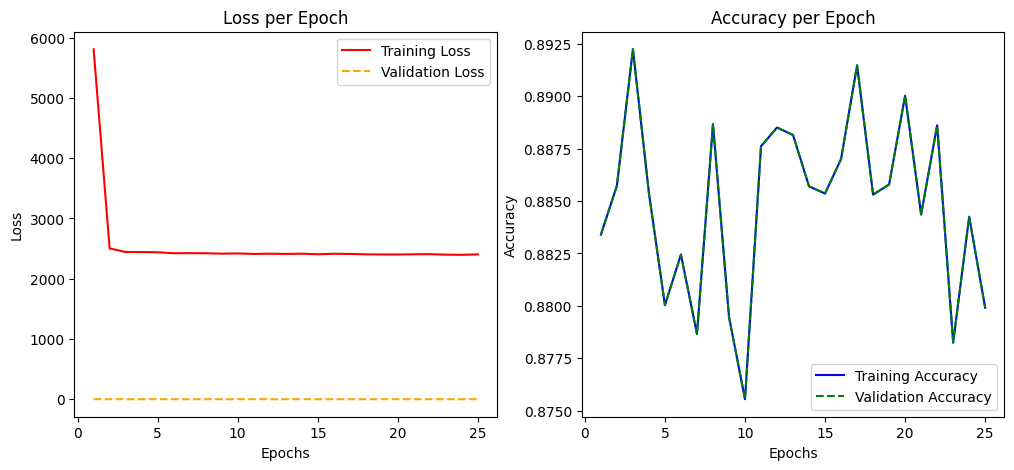

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

np.random.seed(28)

class FullyConnectedNeuralNetwork:
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size, activation='sigmoid', initialization="Xavier", dropout_rate=0.5):
        if initialization == "Xavier":
            self.w1 = np.random.randn(input_size, hidden_size_1) * np.sqrt(2 / input_size)
            self.w2 = np.random.randn(hidden_size_1, hidden_size_2) * np.sqrt(2 / hidden_size_1)
            self.w3 = np.random.randn(hidden_size_2, output_size) * np.sqrt(2 / hidden_size_2)
            self.b1 = np.ones((1, hidden_size_1))
            self.b2 = np.ones((1, hidden_size_2))
            self.b3 = np.ones((1, output_size))
        elif initialization == "he":
            self.w1 = np.random.randn(input_size, hidden_size_1) * np.sqrt(1 / input_size)
            self.w2 = np.random.randn(hidden_size_1, hidden_size_2) * np.sqrt(1 / hidden_size_1)
            self.w3 = np.random.randn(hidden_size_2, output_size) * np.sqrt(1 / hidden_size_2)
        else:
            self.w1, self.w2, self.w3 = self.initialize_weights(input_size, hidden_size_1, hidden_size_2, output_size)

# layer Normalization Parameters
        self.gamma1 = np.ones((1, hidden_size_1))
        self.beta1 = np.zeros((1, hidden_size_1))
        self.running_mean1 = np.zeros((1, hidden_size_1))
        self.running_var1 = np.ones((1, hidden_size_1))

        self.gamma2 = np.ones((1, hidden_size_2))
        self.beta2 = np.zeros((1, hidden_size_2))
        self.running_mean2 = np.zeros((1, hidden_size_2))
        self.running_var2 = np.ones((1, hidden_size_2))

        self.reg_lambda = 0.01
        self.dropout_rate = dropout_rate
        self.set_activation(activation)
        self.training = True  # Mode control: True for training, False for testing

    def set_training_mode(self, mode):
        """Switch between training and testing modes."""
        self.training = mode
    def layer_norm(self, x, gamma, beta, running_mean, running_var, epsilon=1e-5, momentum=0.9):
        """Batch normalization implementation."""
        batch_mean = np.mean(x, axis=1, keepdims=True)
        batch_var = np.var(x, axis=1, keepdims=True)

        # Normalize
        x_norm = (x - batch_mean) / np.sqrt(batch_var + epsilon)
        out = gamma * x_norm + beta

        return out

    def apply_dropout(self, layer_output, layer_name):
        """Apply dropout to the layer output during training and store the mask."""
        if self.training:
            dropout_mask = (np.random.rand(*layer_output.shape) > self.dropout_rate).astype(np.float32)
            setattr(self, f"{layer_name}_mask", dropout_mask)  # Dynamically create mask attribute
            return layer_output * dropout_mask  # Apply the mask
        else:
            return layer_output * (1 - self.dropout_rate)

    def set_activation(self, activation):
        """Set activation function and its derivative based on user input."""
        activations = {
            'sigmoid': (self.sigmoid, self.sigmoid_derivative),
            'relu': (self.relu, self.relu_derivative),
            'tanh': (self.tanh, self.tanh_derivative),
            'leaky_relu': (self.leaky_relu, self.leaky_relu_derivative),
            'elu': (self.elu, self.elu_derivative),
            'selu': (self.selu, self.selu_derivative)
        }
        if activation in activations:
            self.activation, self.activation_derivative = activations[activation]
        else:
            raise ValueError(f"Invalid activation function '{activation}'. Choose from {list(activations.keys())}.")

    def sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def relu(self, x):
        return np.maximum(0,x)

    def tanh(self,x):
        return np.tanh(x)

    def leaky_relu(self,x,alpha=0.01):
        return np.maximum(alpha*x,x)

    def elu(self,x,alpha=1.0):
        return np.where(x>0,x,alpha*(np.exp(x)-1))

    def selu(self,x):
        alpha = 1.67326324235437728481704299167
        scale = 1.05070098735548049341933498529
        return scale * np.where(x > 0, x, alpha * (np.exp(x) - 1))

    def elu_derivative(self, x, alpha=1.0):
        return np.where(x > 0, 1, alpha * np.exp(x))

    def selu_derivative(self, x):
        alpha = 1.67326324235437728481704299167
        scale = 1.05070098735548049341933498529
        return scale * np.where(x > 0, 1, alpha * np.exp(x))

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def leaky_relu_derivative(self, x, alpha=0.01):
        return np.where(x > 0, 1, alpha)

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X):
        """Forward pass with dropout applied during training."""
        self.a1 = np.dot(X, self.w1) + self.b1
        self.a1_bn = self.layer_norm(self.a1, self.gamma1, self.beta1, self.running_mean1, self.running_var1)
        self.h1 = self.activation(self.a1)
        self.h1 = self.apply_dropout(self.h1, "layer1")  # Store mask1 as an attribute

        self.a2 = np.dot(self.h1, self.w2) + self.b2
        self.a2_bn = self.layer_norm(self.a2, self.gamma2, self.beta2, self.running_mean2, self.running_var2)
        self.h2 = self.activation(self.a2)
        self.h2 = self.apply_dropout(self.h2, "layer2")  # Store mask2 as an attribute

        self.a3 = np.dot(self.h2, self.w3) + self.b3
        self.output = self.softmax(self.a3)
        return self.output

    def compute_loss(self, y_true, y_pred):
        n_samples = y_true.shape[0]
        epsilon = 1e-9
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.sum(y_true * np.log(y_pred)) / n_samples

        reg_loss = (self.reg_lambda / 2) * (np.sum(self.w1 ** 2) + np.sum(self.w2 ** 2) + np.sum(self.w3 ** 2))
        return loss + reg_loss

    def backward(self, X, y, learning_rate):
        n_samples = X.shape[0]

        # Output layer
        output_delta = -(y - self.output)

        # Hidden layer 2
        hidden_error_1 = np.dot(output_delta, self.w3.T)
        hidden_delta_1 = hidden_error_1 * self.activation_derivative(self.h2)
        hidden_delta_1 *= self.layer2_mask  # Use stored mask2

        # Hidden layer 1
        hidden_error_2 = np.dot(hidden_delta_1, self.w2.T)
        hidden_delta_2 = hidden_error_2 * self.activation_derivative(self.h1)
        hidden_delta_2 *= self.layer1_mask  # Use stored mask1

        # Update weights and biases with regularization
        self.w3 -= learning_rate * ((np.dot(self.h2.T, output_delta) / n_samples) + self.reg_lambda * self.w3)
        self.b3 -= learning_rate * (np.mean(output_delta, axis=0, keepdims=True) / n_samples)

        self.w2 -= learning_rate * ((np.dot(self.h1.T, hidden_delta_1) / n_samples) + self.reg_lambda * self.w2)
        self.b2 -= learning_rate * (np.mean(hidden_delta_1, axis=0, keepdims=True) / n_samples)

        self.w1 -= learning_rate * ((np.dot(X.T, hidden_delta_2) / n_samples) + self.reg_lambda * self.w1)
        self.b1 -= learning_rate * (np.mean(hidden_delta_2, axis=0, keepdims=True) / n_samples)
X_train = train_df.drop('label', axis=1).values / 255.0
y_train = train_df['label'].values

num_classes = 10
y_train_encoded = np.zeros((len(y_train), num_classes))
y_train_encoded[np.arange(len(y_train)), y_train] = 1


input_size = X_train.shape[1]
hidden_size_1 = 512
hidden_size_2 = 128
output_size = 10
learning_rate = 0.1
epochs = 25
batch_size = 24
activation_function = 'leaky_relu'

# Training with Early Stopping
def train_model(nn, X_train, y_train, batch_size, epochs, learning_rate, patience=5):
    losses = []
    accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_val_loss = 0
        num_batches = int(np.ceil(len(X_train) / batch_size))

        # Set model to training mode
        nn.set_training_mode(True)

        for i in range(num_batches):
            X_batch = X_train[i * batch_size:(i + 1) * batch_size]
            y_batch = y_train[i * batch_size:(i + 1) * batch_size]

            nn.forward(X_batch)  # Forward pass
            epoch_loss += nn.compute_loss(y_batch, nn.output)  # Compute loss
            nn.backward(X_batch, y_batch, learning_rate)  # Backpropagation

        # Calculate accuracy for the epoch
        nn.set_training_mode(False)  # Set model to evaluation mode
        nn.forward(X_train)  # Forward pass without dropout
        y_pred = np.argmax(nn.output, axis=1)
        y_true = np.argmax(y_train, axis=1)
        accuracy = accuracy_score(y_true, y_pred)

        # Validation loss and accuracy
        val_loss = epoch_loss / num_batches  # You can modify this calculation to use validation data
        val_accuracy = accuracy  # Similarly, calculate validation accuracy if needed

        # Store loss and accuracy for both training and validation
        losses.append(epoch_loss)
        accuracies.append(accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}: Loss = {losses[-1]:.4f}, Accuracy = {accuracy:.4f}, "
              f"Val Loss = {val_losses[-1]:.4f}, Val Accuracy = {val_accuracies[-1]:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}. Best Val Loss: {best_val_loss:.4f}.")
                break

    return losses, accuracies, val_losses, val_accuracies
def plot_metrics(losses, accuracies, val_losses, val_accuracies):
    epochs = range(1, len(losses) + 1)
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, label='Training Loss', color='red')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, label='Training Accuracy', color='blue')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.show()


# Confusion matrix
def plot_confusion_matrix(nn, X, y_true):
    nn.set_training_mode(False)  # Set model to evaluation mode
    nn.forward(X)  # Forward pass without dropout
    y_pred = np.argmax(nn.output, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='viridis')
    plt.title("Confusion Matrix")
    plt.show()

# Count trainable parameters
def count_parameters(nn):
    params = sum(w.size for w in [nn.w1, nn.w2, nn.w3, nn.b1, nn.b2, nn.b3])
    print(f"Total trainable parameters: {params}")


# Example usage:
input_size = X_train.shape[1]
hidden_size_1 = 512
hidden_size_2 = 128
output_size = 10
learning_rate = 0.1
epochs = 25
batch_size = 24
activation_function = 'leaky_relu'

nn = FullyConnectedNeuralNetwork(input_size=input_size, hidden_size_1=hidden_size_1, hidden_size_2=hidden_size_2, output_size=output_size, activation=activation_function, dropout_rate=0.5)

# Train the model with early stopping
losses, accuracies, val_losses, val_accuracies = train_model(nn, X_train, y_train_encoded, batch_size, epochs, learning_rate)

# Plot metrics
plot_metrics(losses, accuracies, val_losses, val_accuracies)


